In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

In [2]:
image = cv2.imread('test_image.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [3]:
from narya.utils.vizualization import visualize

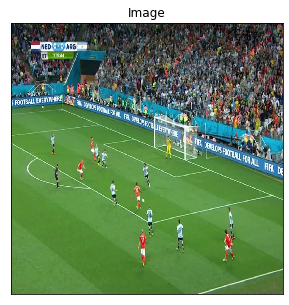

In [4]:
visualize(image=image)

In [5]:
from narya.models.keras_models import DeepHomoModel
from narya.models.keras_models import KeypointDetectorModel
from narya.models.gluon_models import TrackerModel
from narya.models.torch_models import ReIdModel

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [6]:
import tensorflow as tf
from narya.utils.homography import compute_homography, warp_image
from narya.utils.image import torch_img_to_np_img, np_img_to_torch_img, denormalize
from narya.utils.utils import to_torch

# Deep Homo Prediction : 

In [7]:
full_model = DeepHomoModel()

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/deep_homo_model.h5"
)
RESNET_ARCHI_TF_KERAS_NAME = "deep_homo_model.h5"
RESNET_ARCHI_TF_KERAS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                RESNET_ARCHI_TF_KERAS_NAME, RESNET_ARCHI_TF_KERAS_PATH, RESNET_ARCHI_TF_KERAS_TOTAR,
            )

full_model.load_weights(checkpoints)

model = full_model.model
preprocessing_fn = full_model.preprocessing

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/deep_homo_model.h5


In [8]:
corners = full_model(image)

In [9]:
corners

array([[0.25637162, 0.16547665, 0.35084763, 0.53626263, 0.06111866,
        0.43092024, 0.5895886 , 0.3165082 ]], dtype=float32)

In [10]:
template = cv2.imread('world_cup_template.png')
template = cv2.cvtColor(template, cv2.COLOR_BGR2RGB)
template = cv2.resize(template, (1280,720))
template = template/255.


In [12]:
pred_homo = compute_homography(corners)[0]

In [17]:
pred_warp = warp_image(np_img_to_torch_img(template),to_torch(pred_homo),method='torch')[0]

In [19]:
pred_warp = torch_img_to_np_img(pred_warp)

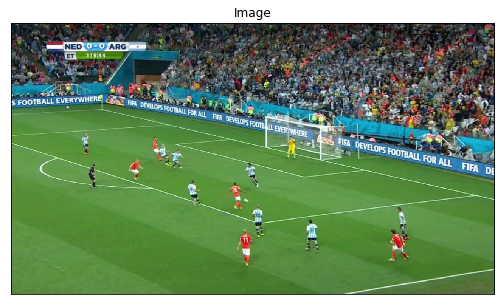

In [24]:
visualize(image=cv2.resize(image, (1280,720)))

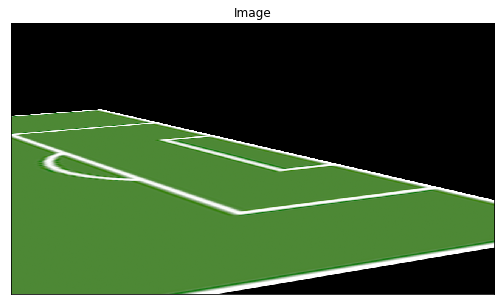

In [22]:
visualize(image=pred_warp)

# Keypoint Detector : 

In [7]:
full_model = KeypointDetectorModel(
    backbone='efficientnetb3', num_classes=29, input_shape=(320, 320),
)

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/keypoint_detector.h5"
)
RESNET_ARCHI_TF_KERAS_NAME = "keypoint_detector.h5"
RESNET_ARCHI_TF_KERAS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                RESNET_ARCHI_TF_KERAS_NAME, RESNET_ARCHI_TF_KERAS_PATH, RESNET_ARCHI_TF_KERAS_TOTAR,
            )

full_model.load_weights(checkpoints)

model = full_model.model
preprocessing_fn = full_model.preprocessing

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/keypoint_detector.h5


In [8]:
pr_mask = full_model(image)

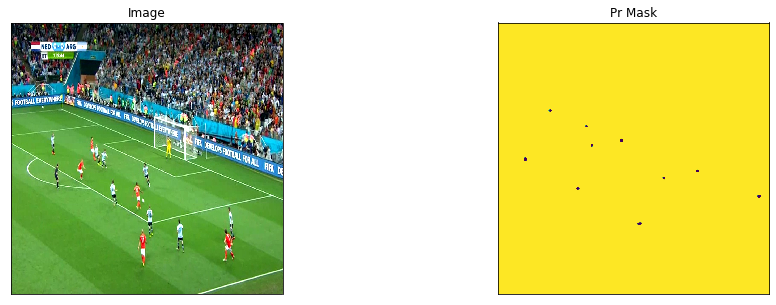

In [11]:
visualize(
        image=denormalize(image.squeeze()),
        pr_mask=pr_mask[..., -1].squeeze(),
    )

# Player/Ball Tracker : 

In [7]:
full_model = TrackerModel(pretrained=True, backbone='ssd_512_resnet50_v1_coco')

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/player_tracker.params"
)
RESNET_ARCHI_TF_KERAS_NAME = "player_tracker.params"
RESNET_ARCHI_TF_KERAS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                RESNET_ARCHI_TF_KERAS_NAME, RESNET_ARCHI_TF_KERAS_PATH, RESNET_ARCHI_TF_KERAS_TOTAR,
            )

full_model.load_weights(checkpoints)

model = full_model.model
preprocessing_fn = full_model.preprocessing

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/player_tracker.params


In [8]:
cid, score, bbox = full_model(image)

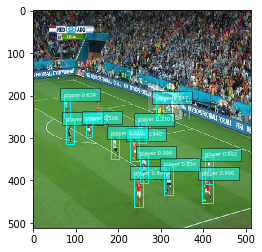

In [9]:
from gluoncv.utils import viz
ax = viz.plot_bbox(cv2.resize(image,(512,512)), bbox[0], score[0], cid[0], class_names=model.classes,thresh=0.5,linewidth=1,fontsize=5)
plt.show()

In [10]:
bbox = bbox.asnumpy()
x_1 = int(bbox[0][0][0])
y_1 = int(bbox[0][0][1])
x_2 = int(bbox[0][0][2])
y_2 = int(bbox[0][0][3])
print(x_1,x_2,y_1,y_2)

237 258 387 462


# Player embedding extractor : 

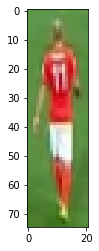

In [11]:
resized_image = cv2.resize(image,(512,512))
plt.imshow(resized_image[y_1:y_2,x_1:x_2])

In [12]:
full_model = ReIdModel()

RESNET_ARCHI_TF_KERAS_PATH = (
    "https://storage.googleapis.com/narya-bucket-1/models/player_reid.pth"
)
RESNET_ARCHI_TF_KERAS_NAME = "player_reid.pth"
RESNET_ARCHI_TF_KERAS_TOTAR = False

checkpoints = tf.keras.utils.get_file(
                RESNET_ARCHI_TF_KERAS_NAME, RESNET_ARCHI_TF_KERAS_PATH, RESNET_ARCHI_TF_KERAS_TOTAR,
            )

full_model.load_weights(checkpoints)

model = full_model.model
preprocessing_fn = full_model.preprocessing

Succesfully loaded weights from /Users/paulgarnier/.keras/datasets/player_reid.pth


In [13]:
player_img = resized_image[y_1:y_2,x_1:x_2]
embedding = full_model(player_img)

In [16]:
embedding

array([[ 1.87090427e-01,  2.72104025e-01,  3.02542615e+00,
         4.54795408e+00,  2.15320539e+00,  1.49750125e+00,
        -3.73467535e-01,  2.62292624e-01, -8.85763988e-02,
         5.33042215e-02, -1.15579136e-01, -1.65511549e-01,
         1.61501610e+00, -8.05647671e-03, -2.56434655e+00,
        -5.68352230e-02, -2.17521334e+00, -1.54059112e+00,
         2.16827440e+00,  5.20075893e+00,  9.01143134e-01,
         1.16248405e+00,  1.44482183e+00,  3.99931407e+00,
         1.37739182e+00, -4.89053667e-01,  3.88076425e-01,
         6.10780478e-01, -2.84040236e+00,  2.67522093e-02,
        -6.61602616e-01, -2.50354886e-01,  1.77776635e+00,
         6.58208802e-02,  1.57315505e+00,  8.50535393e-01,
         1.35569465e+00, -1.94606614e+00,  1.53417885e+00,
        -8.82200122e-01, -5.60843766e-01,  2.30464649e+00,
        -3.65228564e-01, -3.01657230e-01, -3.74639630e+00,
         6.64015055e-01,  4.83967209e+00,  2.56852794e+00,
         8.35504115e-01,  8.58006179e-01, -3.57525706e-0